In [1]:
import torch
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from pytorch_revgrad import RevGrad

train_MNIST = datasets.MNIST('', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))

test_MNIST = datasets.MNIST('', train=False, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))

train_USPS = datasets.USPS('USPS', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))

test_USPS = datasets.USPS('USPS', train=False, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))

trainset_MNIST = torch.utils.data.DataLoader(train_MNIST, batch_size=32, shuffle=True)
testset_MNIST = torch.utils.data.DataLoader(test_MNIST, batch_size=32, shuffle=False)

trainset_USPS = torch.utils.data.DataLoader(train_USPS, batch_size=32, shuffle=True)
testset_USPS = torch.utils.data.DataLoader(test_USPS, batch_size=32, shuffle=False)

In [2]:
# defining the transformation

p = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32,32)),
    transforms.RandomCrop((28, 28)),
    transforms.ToTensor(),
])

In [11]:
# function that transforms the data according to how it is done in the paper. First interpolating so that images are 32x32 and than performing 'random' 28x28 crop

def transformdata(data):
    data_transformed = [] # initializing the entire (batched) dataset as an empty list
    
    for batch in data:
        
        images = batch[0]
        labels = batch[1]
        
        images_transformed = torch.zeros(size=torch.Size([32, 1, 28, 28])) # initializing the transformed images with the same shape as images (32, 1, 28, 28)

        for i in range(0, len(images)):
            
            image = images[i]
            
            image_transformed = p(image) # transforming the image with predefined transformation "p"
            images_transformed[i] = image_transformed # replacing zero tensor (1, 28, 28) in images_transformed with the transformed image
            
        batch_transformed = [images_transformed, labels] # transformed batch is simply a list of batch of images in [0] and batch of labels in [1]
    
        data_transformed.append(batch_transformed) # appending to the empty dataset list
        
    return data_transformed

In [13]:
# transforming data

train_MNIST_transformed = transformdata(trainset_MNIST)
test_MNIST_transformed = transformdata(testset_MNIST)
train_USPS_transformed = transformdata(trainset_USPS)
test_USPS_transformed = transformdata(testset_USPS)

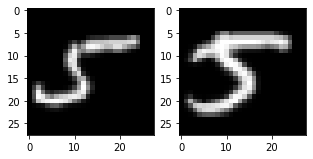

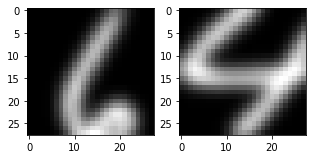

In [21]:
# plotting 2 images from MNIST datset (2 to make sure I didn't make a mistake in transforming the dataset)

batch_MNIST_0 = train_MNIST_transformed[0]
images0 = batch_MNIST_0[0]

plt.figure(figsize=(5,5)) # specifying the overall grid size

for i in range(2):
    plt.subplot(1,2,i+1)    # the number of images in the grid is 5*5 (25)
    plt.imshow(images0[i].view(28,28), cmap="gray")

plt.show()

# plotting 2 images from USPS datset (2 to make sure I didn't make a mistake in transforming the dataset)

batch_USPS_0 = train_USPS_transformed[0]

images0 = batch_USPS_0[0]

plt.figure(figsize=(5,5)) # specifying the overall grid size


for i in range(2):
    plt.subplot(1,2,i+1)    # the number of images in the grid is 5*5 (25)
    plt.imshow(images0[i].view(28,28), cmap="gray")

plt.show()



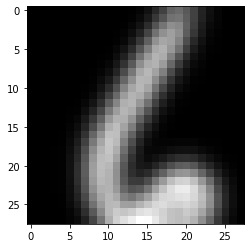

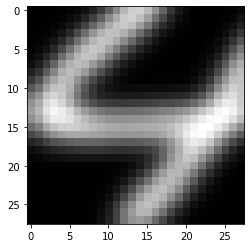

7296


In [15]:
# plotting 2 images from USPS datset (2 to make sure I didn't make a mistake in transforming the dataset)

batch_USPS_0 = train_USPS_transformed[0]

images0 = batch_USPS_0[0]
image0 = images0[0]
image1 = images0[1]

plt.imshow(image0.view(28,28), cmap="gray")
plt.show()

plt.imshow(image1.view(28,28), cmap="gray")
plt.show()

print(len(train_USPS_transformed)*32)

In [9]:
import torch.nn as nn
import torch.nn.functional as F
# from model import fNet, gNet, Discriminator, hSim, SimNet

In [10]:
def init_weights_disc(m):
    if type(m) == nn.Linear:
        nn.init.uniform_(m.weight)
        nn.init.uniform_(m.bias)
#         m.bias.data.uniform_()
#         m.bias.data.fill_(0.01) # do we need something like this?

In [11]:
# take prototypes from MNIST (in the future they have to be chosen randomly --> shuffle?)
prototype_images = [0] * 10

for source_data in train_MNIST_transformed:
    X_source, y_source = source_data
    
    for j in range(0, len(y_source)):
        
        if torch.sum(torch.Tensor(prototype_images[int(y_source[j])])) == 0:
            prototype_images[int(y_source[j])] = X_source[j].view(1, 1, 28, 28) 

In [12]:
class fNet(nn.Module):
    def __init__(self):
        super(fNet, self).__init__()
        
        self.restored = False

        self.conv1 = nn.Conv2d(1, 64, 5)   # 1st conv layer INPUT [1 x 28 x 28] OUTPUT [64 x 12 x 12]
        self.conv2 = nn.Conv2d(64, 64, 5)  # 2nd conv layer INPUT [64 x 12 x 12] OUTPUT [64 x 4 x 4]
        self.conv3 = nn.Conv2d(64, 128, 5) # 3rd conv layer INPUT [64 x 4 x 4] OUTPUT [128 x 1 x 1]
        self.bn1 = nn.BatchNorm2d(64, eps=1e-05) # batch normalisation
        self.pool = nn.MaxPool2d(2, 2, padding=1)
         
    def forward(self, x):
        output = self.pool(F.relu(self.bn1(self.conv1(x))))
        output = self.pool(F.relu(self.bn1(self.conv2(output))))
        output = F.relu(self.conv3(output))
        output = output.view(-1, 128 * 1 * 1)
        return output
    
    
class gNet(nn.Module):
    def __init__(self):
        super(gNet, self).__init__()
        
        self.restored = False
                
        self.conv1 = nn.Conv2d(1, 64, 5)      # 1st conv layer INPUT [1 x 28 x 28]  OUTPUT [64 x 12 x 12]
        self.conv2 = nn.Conv2d(64, 64, 5)     # 2nd conv layer INPUT [64 x 12 x 12] OUTPUT [64 x 4 x 4]
        self.conv3 = nn.Conv2d(64, 128, 5)    # 3rd conv layer INPUT [64 x 4 x 4]   OUTPUT [128 x 1 x 1]
        self.bn1 = nn.BatchNorm2d(64, eps=1e-05) # batch normalisation
        self.pool = nn.MaxPool2d(2, 2, padding=1)
        
         
    def forward(self, x):
        output = self.pool(F.relu(self.bn1(self.conv1(x))))
        output = self.pool(F.relu(self.bn1(self.conv2(output))))
        output = F.relu(self.conv3(output))
        output = output.view(-1, 128 * 1 *1)
        return output


    def calcproto(self, class_list):
        
        g_output = []
        
        for class_image in class_list:
            g_output_class = self.forward(class_image)
            g_output.append(g_output_class)
        
        num_classes = len(g_output) # number of classes (10 in Digits experiment)
        num_features = g_output_class.shape[1] # number of features (128 in Digits experiment)
            
        prototypes = torch.Tensor(size=torch.Size([num_features, num_classes]))
        
        class_count = 0
        
        for g_output_class in g_output:
            
            prototype = torch.mean(g_output_class, dim=0) # calculating the prototype for each class while testing
            prototypes[:,class_count] = prototype
                        
            class_count += 1
                    
        return prototypes
    
    
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.restored = False

        
        self.layer = nn.Sequential(
            nn.Linear(128, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2),
            RevGrad()
        )
        
    def forward(self, x):
        output = self.layer(x)
        
        output = output/torch.max(output)

        output = F.softmax(output, dim=1) 
#         print(output)
        
        
        return output[:, 0]
    
    
class hSim(nn.Module):
    def __init__(self):
        super().__init__()
    

        self.restored = False
        
        
        self.U = nn.Parameter(torch.rand(size=(512, 128), requires_grad=True))
        self.V = nn.Parameter(torch.rand(size=(512, 128), requires_grad=True))
        
    def forward(self, f_batch, mu_c):
        
        h_batch = torch.zeros(size=[32, 10]) # batchsize = 32 maybe 'automate' this size so we don't get in trouble later      when we may change the batch size (same goes for number of classes (10))
        
        
        for i in range(0, len(f_batch)):
        
            f_i = f_batch[i]
            fac1 = torch.matmul(self.U, f_i)
            fac1_t = fac1.t()
                        
            fac2 = torch.matmul(self.V, mu_c)
    
            h = torch.matmul(fac1_t, fac2)
#             h = F.softmax(h/torch.max(h), dim=0)
            
            
            h_batch[i] = h
            
        
        return h_batch   
    
    
class SimNet(nn.Module):
    def __init__(self):
        super().__init__()
    
        self.restored = False
    
        self.fnet = fNet()
        self.gnet = gNet()
        self.disc = Discriminator()
        self.hsim = hSim()
        
        
    def forward(self, f_input, g_input):
        # f_input is batch of images
        # g_input should be a list (in the future maybe change to tensor?) of one (while training --> randomly chosen) or more (while testing --> every from test_batch) image(s) of every class
        
        f_output = self.fnet(f_input)
        prototypes = self.gnet.calcproto(g_input)
                        
        Regularizer = torch.norm(torch.matmul(prototypes, prototypes.t()) - torch.eye(128))
        Regularizer = Regularizer*Regularizer
                
        class_output = self.hsim(f_output, prototypes)
        disc_output = self.disc(f_output)
        
        return [class_output, disc_output, Regularizer] 

In [48]:
gamma_reg = 0.01
lambda_loss= 0.5

simnet = SimNet()
simnet.apply(init_weights_disc)

optimizerSimNet = torch.optim.SGD([
                                    {'params': simnet.disc.parameters(), 'lr': 1e-2},
                                    {'params': simnet.hsim.parameters(), 'lr': 1e-2},
                                    {'params': simnet.fnet.parameters()},
                                    {'params': simnet.gnet.parameters()}],                                 
                                lr=1e-3, momentum=0.99, weight_decay=1e-5)

loss_class = 0
loss_disc = 0

for epoch in range(3): # 3 full passes over the data
    
    num_batches = len(train_USPS_transformed)

    for i in range(0, num_batches):
        
        MNIST_batch = train_MNIST_transformed[i]
        USPS_batch = train_USPS_transformed[i]
        
        X_MNIST, y_MNIST = MNIST_batch
        X_USPS, y_USPS = USPS_batch
                
        simnet.zero_grad()
#         optimizerSimNet.zero_grad()
                
        [source_class_output, source_domain_output, Regularizer] = simnet(X_MNIST, prototype_images)
        [target_class_output, target_domain_output, Regularizer] = simnet(X_USPS, prototype_images)
        
        
        loss_class = 0
        
###### 'Our' implementation of classifier loss as described in the paper ######
                
       #for j in range(0,len(y_MNIST)):
            #h_jj = source_class_output[j][y_MNIST[j]]
            #h_jk = torch.exp(source_class_output[j])
            #h_k = torch.sum(h_jk)
            
            #loss_class -= (h_jj - torch.log(h_k + 1e-7))
            
        #print(Regularizer) # this gets absurdly large?
            
        #loss_class += Regularizer

##### Cross_entropy classifier loss #####
            
        # For cross_entropy loss to work you have to uncomment F.softmax in forward function of hSim()    
        
        #loss_class = F.cross_entropy(source_class_output, y_MNIST) + gamma_reg * Regularizer
        
        
        loss_disc = - torch.sum(torch.log(source_domain_output + 1e-7)) - torch.sum(torch.log(1 - target_domain_output+1e-7))

        total_loss = loss_class - lambda_loss * loss_disc        
        total_loss.backward()
        
        optimizerSimNet.step()
        
        print("loss_class: " + str(loss_class))
        print("loss_disc: " + str(loss_disc))
        
#         if i == num_batches-1:
#             print("loss_class: " + str(loss_class))
#             print("loss_disc: " + str(loss_disc))

tensor(13428.2197, grad_fn=<MulBackward0>)
loss_class: tensor(73.7037, grad_fn=<SubBackward0>)
loss_disc: tensor(44.3623, grad_fn=<SubBackward0>)
tensor(13580.4102, grad_fn=<MulBackward0>)
loss_class: tensor(73.6626, grad_fn=<SubBackward0>)
loss_disc: tensor(44.3540, grad_fn=<SubBackward0>)
tensor(14042.3174, grad_fn=<MulBackward0>)
loss_class: tensor(73.7202, grad_fn=<SubBackward0>)
loss_disc: tensor(44.3625, grad_fn=<SubBackward0>)
tensor(14532.9473, grad_fn=<MulBackward0>)
loss_class: tensor(73.7794, grad_fn=<SubBackward0>)
loss_disc: tensor(44.3589, grad_fn=<SubBackward0>)
tensor(15018.6602, grad_fn=<MulBackward0>)
loss_class: tensor(73.6586, grad_fn=<SubBackward0>)
loss_disc: tensor(44.3606, grad_fn=<SubBackward0>)
tensor(15457.3652, grad_fn=<MulBackward0>)
loss_class: tensor(73.7364, grad_fn=<SubBackward0>)
loss_disc: tensor(44.3570, grad_fn=<SubBackward0>)
tensor(16183.5020, grad_fn=<MulBackward0>)
loss_class: tensor(73.8470, grad_fn=<SubBackward0>)
loss_disc: tensor(44.3573, gr

RuntimeError: select(): index 0 out of range for tensor of size [0, 1] at dimension 0
Exception raised from select at ..\aten\src\ATen\native\TensorShape.cpp:889 (most recent call first):
00007FFB9BF06AD600007FFB9BF06A70 c10.dll!c10::Error::Error [<unknown file> @ <unknown line number>]
00007FFB9BEE387C00007FFB9BEE3800 c10.dll!c10::IndexError::IndexError [<unknown file> @ <unknown line number>]
00007FFB45D55ED100007FFB45D55A10 torch_cpu.dll!at::native::select [<unknown file> @ <unknown line number>]
00007FFB4602A9FE00007FFB45FAB700 torch_cpu.dll!at::zeros_out [<unknown file> @ <unknown line number>]
00007FFB45AF844A00007FFB45AED8A0 torch_cpu.dll!torch::nn::functional::BatchNormFuncOptions::~BatchNormFuncOptions [<unknown file> @ <unknown line number>]
00007FFB45EF843A00007FFB45E73840 torch_cpu.dll!at::native::mkldnn_sigmoid_ [<unknown file> @ <unknown line number>]
00007FFB45F9751100007FFB45F97450 torch_cpu.dll!at::select [<unknown file> @ <unknown line number>]
00007FFB4714FDA500007FFB47137970 torch_cpu.dll!torch::autograd::GraphRoot::apply [<unknown file> @ <unknown line number>]
00007FFB45AF844A00007FFB45AED8A0 torch_cpu.dll!torch::nn::functional::BatchNormFuncOptions::~BatchNormFuncOptions [<unknown file> @ <unknown line number>]
00007FFB45EF843A00007FFB45E73840 torch_cpu.dll!at::native::mkldnn_sigmoid_ [<unknown file> @ <unknown line number>]
00007FFB4606026100007FFB460601A0 torch_cpu.dll!at::Tensor::select [<unknown file> @ <unknown line number>]
00007FFB470DB3F900007FFB470DB050 torch_cpu.dll!torch::autograd::SavedVariable::reset_grad_function [<unknown file> @ <unknown line number>]
00007FFB470A0EC400007FFB470A0D90 torch_cpu.dll!torch::autograd::generated::MaxBackward1::apply [<unknown file> @ <unknown line number>]
00007FFB4707D96700007FFB4707D760 torch_cpu.dll!torch::autograd::Node::operator() [<unknown file> @ <unknown line number>]
00007FFB475559F900007FFB475554A0 torch_cpu.dll!torch::autograd::Engine::add_thread_pool_task [<unknown file> @ <unknown line number>]
00007FFB475565A500007FFB47556290 torch_cpu.dll!torch::autograd::Engine::evaluate_function [<unknown file> @ <unknown line number>]
00007FFB4755B52C00007FFB4755B220 torch_cpu.dll!torch::autograd::Engine::thread_main [<unknown file> @ <unknown line number>]
00007FFB47557BFF00007FFB47557A10 torch_cpu.dll!torch::autograd::Engine::execute_with_graph_task [<unknown file> @ <unknown line number>]
00007FFB6859307800007FFB6856C550 torch_python.dll!THPShortStorage_New [<unknown file> @ <unknown line number>]
00007FFB4755793D00007FFB47557600 torch_cpu.dll!torch::autograd::Engine::execute [<unknown file> @ <unknown line number>]
00007FFB68592F4400007FFB6856C550 torch_python.dll!THPShortStorage_New [<unknown file> @ <unknown line number>]
00007FFB6859190000007FFB6856C550 torch_python.dll!THPShortStorage_New [<unknown file> @ <unknown line number>]
00007FFB6CFDE9F500007FFB6CFDE6A0 python37.dll!PyMethodDef_RawFastCallKeywords [<unknown file> @ <unknown line number>]
00007FFB6CFDF2BF00007FFB6CFDE6A0 python37.dll!PyMethodDef_RawFastCallKeywords [<unknown file> @ <unknown line number>]
00007FFB6CFE04E900007FFB6CFDF4F0 python37.dll!PyEval_EvalFrameDefault [<unknown file> @ <unknown line number>]
00007FFB6CFC8EB600007FFB6CFC8D10 python37.dll!PyEval_EvalCodeWithName [<unknown file> @ <unknown line number>]
00007FFB6CFDF38700007FFB6CFDE6A0 python37.dll!PyMethodDef_RawFastCallKeywords [<unknown file> @ <unknown line number>]
00007FFB6CFDFDA200007FFB6CFDF4F0 python37.dll!PyEval_EvalFrameDefault [<unknown file> @ <unknown line number>]
00007FFB6CFC8EB600007FFB6CFC8D10 python37.dll!PyEval_EvalCodeWithName [<unknown file> @ <unknown line number>]
00007FFB6CFDF38700007FFB6CFDE6A0 python37.dll!PyMethodDef_RawFastCallKeywords [<unknown file> @ <unknown line number>]
00007FFB6CFDF8F300007FFB6CFDF4F0 python37.dll!PyEval_EvalFrameDefault [<unknown file> @ <unknown line number>]
00007FFB6CFC8EB600007FFB6CFC8D10 python37.dll!PyEval_EvalCodeWithName [<unknown file> @ <unknown line number>]
00007FFB6CFA732F00007FFB6CFA718C python37.dll!PyErr_Clear [<unknown file> @ <unknown line number>]
00007FFB6CFA720500007FFB6CFA718C python37.dll!PyErr_Clear [<unknown file> @ <unknown line number>]
00007FFB6CFDE75000007FFB6CFDE6A0 python37.dll!PyMethodDef_RawFastCallKeywords [<unknown file> @ <unknown line number>]
00007FFB6CFDF2BF00007FFB6CFDE6A0 python37.dll!PyMethodDef_RawFastCallKeywords [<unknown file> @ <unknown line number>]
00007FFB6CFDF99F00007FFB6CFDF4F0 python37.dll!PyEval_EvalFrameDefault [<unknown file> @ <unknown line number>]
00007FFB6CFC517400007FFB6CFC4F2C python37.dll!PyObject_GetAttrId [<unknown file> @ <unknown line number>]
00007FFB6D0258AC00007FFB6CFFE9B0 python37.dll!PyErr_NoMemory [<unknown file> @ <unknown line number>]
00007FFB6CFC517400007FFB6CFC4F2C python37.dll!PyObject_GetAttrId [<unknown file> @ <unknown line number>]
00007FFB6D0258AC00007FFB6CFFE9B0 python37.dll!PyErr_NoMemory [<unknown file> @ <unknown line number>]
00007FFB6CFC517400007FFB6CFC4F2C python37.dll!PyObject_GetAttrId [<unknown file> @ <unknown line number>]
00007FFB6CFDE77100007FFB6CFDE6A0 python37.dll!PyMethodDef_RawFastCallKeywords [<unknown file> @ <unknown line number>]
00007FFB6CFDF0FC00007FFB6CFDE6A0 python37.dll!PyMethodDef_RawFastCallKeywords [<unknown file> @ <unknown line number>]
00007FFB6CFDF8F300007FFB6CFDF4F0 python37.dll!PyEval_EvalFrameDefault [<unknown file> @ <unknown line number>]
00007FFB6CFDF25B00007FFB6CFDE6A0 python37.dll!PyMethodDef_RawFastCallKeywords [<unknown file> @ <unknown line number>]
00007FFB6CFDF99F00007FFB6CFDF4F0 python37.dll!PyEval_EvalFrameDefault [<unknown file> @ <unknown line number>]
00007FFB6CFDF25B00007FFB6CFDE6A0 python37.dll!PyMethodDef_RawFastCallKeywords [<unknown file> @ <unknown line number>]
00007FFB6CFDF8F300007FFB6CFDF4F0 python37.dll!PyEval_EvalFrameDefault [<unknown file> @ <unknown line number>]
00007FFB6CFC8EB600007FFB6CFC8D10 python37.dll!PyEval_EvalCodeWithName [<unknown file> @ <unknown line number>]
00007FFB6CFC8B3A00007FFB6CFC8980 python37.dll!PyFunction_FastCallDict [<unknown file> @ <unknown line number>]
00007FFB6CFC7AEA00007FFB6CFC7740 python37.dll!PyMethodDef_RawFastCallDict [<unknown file> @ <unknown line number>]
00007FFB6CFEED1400007FFB6CFEEB60 python37.dll!PySlice_New [<unknown file> @ <unknown line number>]
00007FFB6CFE066400007FFB6CFDF4F0 python37.dll!PyEval_EvalFrameDefault [<unknown file> @ <unknown line number>]
00007FFB6CFC8EB600007FFB6CFC8D10 python37.dll!PyEval_EvalCodeWithName [<unknown file> @ <unknown line number>]
00007FFB6CFDF38700007FFB6CFDE6A0 python37.dll!PyMethodDef_RawFastCallKeywords [<unknown file> @ <unknown line number>]
00007FFB6CFE04E900007FFB6CFDF4F0 python37.dll!PyEval_EvalFrameDefault [<unknown file> @ <unknown line number>]
00007FFB6CFC517400007FFB6CFC4F2C python37.dll!PyObject_GetAttrId [<unknown file> @ <unknown line number>]
00007FFB6D11F35600007FFB6D11BA64 python37.dll!PyAST_Optimize [<unknown file> @ <unknown line number>]
00007FFB6CFDE75000007FFB6CFDE6A0 python37.dll!PyMethodDef_RawFastCallKeywords [<unknown file> @ <unknown line number>]
00007FFB6CFDF2BF00007FFB6CFDE6A0 python37.dll!PyMethodDef_RawFastCallKeywords [<unknown file> @ <unknown line number>]
00007FFB6CFDF99F00007FFB6CFDF4F0 python37.dll!PyEval_EvalFrameDefault [<unknown file> @ <unknown line number>]
00007FFB6CFC8EB600007FFB6CFC8D10 python37.dll!PyEval_EvalCodeWithName [<unknown file> @ <unknown line number>]
00007FFB6CFDF38700007FFB6CFDE6A0 python37.dll!PyMethodDef_RawFastCallKeywords [<unknown file> @ <unknown line number>]


In [45]:
for test_batch in test_MNIST_transformed:
    
    X, y = test_batch
    [class_output, domain_output, Regi] = simnet(X, prototype_images)
    
    print(domain_output)
    print(class_output)
    print(y)
    
    break

tensor([0.4973, 0.4893, 0.4992, 0.4977, 0.4964, 0.4988, 0.4975, 0.4888, 0.4929,
        0.4962, 0.4424, 0.4975, 0.4990, 0.4876, 0.4986, 0.4905, 0.4983, 0.4982,
        0.4856, 0.4981, 0.4984, 0.4988, 0.4983, 0.4843, 0.4934, 0.4892, 0.4986,
        0.4783, 0.4857, 0.4974, 0.4976, 0.4989], grad_fn=<SelectBackward>)
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, n